<a href="https://colab.research.google.com/github/jcmachicao/curso_intro_nn/blob/main/KJNM__nn_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
ruta = 'drive/My Drive/00 Modelos Principales/modelos/uc_modelo_2021_KJNM/'
lista = os.listdir(ruta)
lista.sort()
lista

In [ ]:
X_np = np.load(ruta + 'X_in.npy')
y_np = np.load(ruta + 'y_in.npy')
X_maxs = np.load(ruta + 'X_maxs.npy')
print(X_np.shape, y_np.shape, X_maxs.shape)

(84446, 156) (84446,) (156,)


In [ ]:
y_np

array([10.43,  5.48, 11.11, ..., 17.81, 16.38, 17.  ])

In [ ]:
X_nn = X_np/X_maxs
y_nn = np.round(y_np/20,1)*10
np.unique(y_nn)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

(array([  608.,   749.,  1207.,  2135.,  3607.,  4946., 11497., 22795.,
        26399., 10142.,   361.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <a list of 11 Patch objects>)

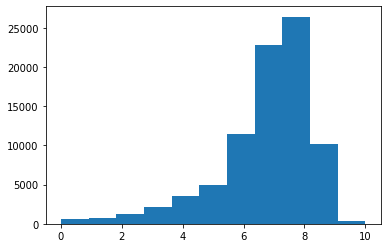

In [ ]:
plt.hist(y_nn, bins=11)

In [ ]:
n_cols = 156
n_cats = 11

In [ ]:
# Arquitectura
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_cols, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, n_cats)
    self.dp1 = nn.Dropout(0.15)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dp1(F.relu(self.fc2(x)))
    x = self.dp1(F.relu(self.fc3(x)))
    x = self.fc4(x)

    return F.log_softmax(x, dim=1)

model = Net()

In [ ]:
modelo_load = ruta + 'modelo_uc_KJNM_v5.pth'
model.load_state_dict(torch.load(modelo_load, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
X_ts = torch.from_numpy(X_nn[80000:]).float()
y_ts = torch.from_numpy(y_nn[80000:]).long()
X_ts.shape, y_ts.shape

(torch.Size([4446, 156]), torch.Size([4446]))

In [ ]:
pred_df = pd.DataFrame()
out = model(X_ts.float())
y_hat = torch.argmax(out, 1).detach()

In [ ]:
pred_df['y_orig'] = y_ts.long()
pred_df['y_hat'] = y_hat
pred_df['aciertos'] = (pred_df.y_orig == pred_df.y_hat)*1
print(pred_df.aciertos.sum()/len(X_ts))
pred_df

0.3367071524966262


,y_orig,y_hat,aciertos
0,7,7,1
1,8,9,0
2,8,8,1
3,7,8,0
4,6,8,0
...,...,...,...
4441,7,7,1
4442,5,5,1
4443,9,9,1
4444,8,6,0


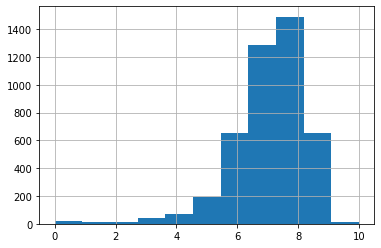

In [ ]:
pred_df.y_orig.hist(bins=20)

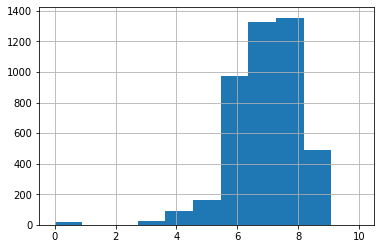

In [ ]:
pred_df.y_hat.hist(bins=20)

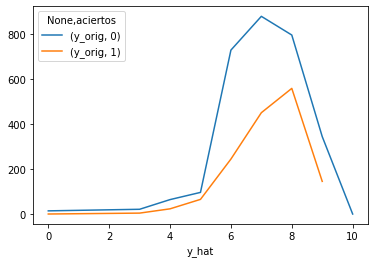

In [ ]:
matrix = pd.pivot_table(pred_df, index='y_hat', columns='aciertos', aggfunc='count')
matrix.plot()

In [ ]:
pred_df.to_excel(ruta + 'pred_KJNM_v5_tot_'+'.xlsx')

In [ ]:
matrix

y_orig       
aciertos      0      1
y_hat                 
0          15.0    1.0
3          22.0    5.0
4          65.0   24.0
5          97.0   66.0
6         729.0  245.0
7         879.0  451.0
8         796.0  559.0
9         345.0  146.0
10          1.0    NaN

In [ ]:
matrix2 = pd.pivot_table(pred_df, values='aciertos', index='y_hat', columns='y_orig', aggfunc='sum')
matrix2

y_orig,0,1,2,3,4,5,6,7,8,9,10
y_hat,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,24.0,0.0,NaN,NaN,NaN,NaN,NaN
5,0.0,0.0,0.0,0.0,0.0,66.0,0.0,0.0,0.0,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,0.0,245.0,0.0,0.0,0.0,NaN
7,NaN,NaN,NaN,NaN,NaN,0.0,0.0,451.0,0.0,0.0,0.0
8,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,559.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,146.0,0.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
